##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [3]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights=None)  # weights="imagenet"  also work

pre_trained_model.load_weights(local_weights_file)   # if weights=None

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2021-02-13 15:11:48--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  47.6MB/s    in 1.8s    

2021-02-13 15:11:51 (47.6 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


In [9]:
last_layer.output, last_layer

(<KerasTensor: shape=(None, 7, 7, 768) dtype=float32 (created by layer 'mixed7')>,
 <tensorflow.python.keras.layers.merge.Concatenate at 0x7f5bc00976d8>)

In [10]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [14]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2021-02-13 15:30:30--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   115MB/s    in 0.6s    

2021-02-13 15:30:31 (115 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 26s - loss: 0.3395 - accuracy: 0.8655 - val_loss: 0.1117 - val_accuracy: 0.9540
Epoch 2/20
100/100 - 17s - loss: 0.2166 - accuracy: 0.9140 - val_loss: 0.1191 - val_accuracy: 0.9560
Epoch 3/20
100/100 - 17s - loss: 0.1960 - accuracy: 0.9245 - val_loss: 0.1161 - val_accuracy: 0.9640
Epoch 4/20
100/100 - 17s - loss: 0.1950 - accuracy: 0.9305 - val_loss: 0.3593 - val_accuracy: 0.9110
Epoch 5/20
100/100 - 17s - loss: 0.1875 - accuracy: 0.9325 - val_loss: 0.1166 - val_accuracy: 0.9680
Epoch 6/20
100/100 - 17s - loss: 0.1721 - accuracy: 0.9395 - val_loss: 0.1796 - val_accuracy: 0.9470
Epoch 7/20
100/100 - 17s - loss: 0.1717 - accuracy: 0.9400 - val_loss: 0.1085 - val_accuracy: 0.9680
Epoch 8/20
100/100 - 17s - loss: 0.1782 - accuracy: 0.9400 - val_loss: 0.1090 - val_accuracy: 0.9640
Epoch 9/20
100/100 - 17s - loss: 0.1344 - accuracy: 0.9580 - val_loss: 0.1553 - val_accuracy: 0.9600
Epoch 10/20
100/100 - 17s - loss: 0.1805 - accuracy: 0.9420 - val_loss: 0.1356 - val_accura

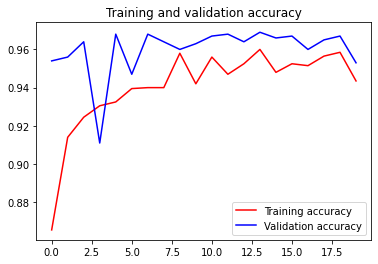

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [17]:
# try to use model without dropout
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)                
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [19]:
history = model.fit(
            train_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_data = validation_generator,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 20s - loss: 0.3131 - accuracy: 0.8680 - val_loss: 0.1156 - val_accuracy: 0.9590
Epoch 2/20
100/100 - 16s - loss: 0.2116 - accuracy: 0.9110 - val_loss: 0.1350 - val_accuracy: 0.9540
Epoch 3/20
100/100 - 16s - loss: 0.2059 - accuracy: 0.9180 - val_loss: 0.1104 - val_accuracy: 0.9620
Epoch 4/20
100/100 - 16s - loss: 0.1850 - accuracy: 0.9280 - val_loss: 0.1240 - val_accuracy: 0.9560
Epoch 5/20
100/100 - 17s - loss: 0.1542 - accuracy: 0.9420 - val_loss: 0.1320 - val_accuracy: 0.9550
Epoch 6/20
100/100 - 17s - loss: 0.1586 - accuracy: 0.9345 - val_loss: 0.1239 - val_accuracy: 0.9630
Epoch 7/20
100/100 - 17s - loss: 0.1541 - accuracy: 0.9440 - val_loss: 0.1199 - val_accuracy: 0.9650
Epoch 8/20
100/100 - 16s - loss: 0.1685 - accuracy: 0.9435 - val_loss: 0.0929 - val_accuracy: 0.9700
Epoch 9/20
100/100 - 16s - loss: 0.1557 - accuracy: 0.9375 - val_loss: 0.1013 - val_accuracy: 0.9680
Epoch 10/20
100/100 - 16s - loss: 0.1344 - accuracy: 0.9490 - val_loss: 0.1207 - val_accura

<Figure size 432x288 with 0 Axes>

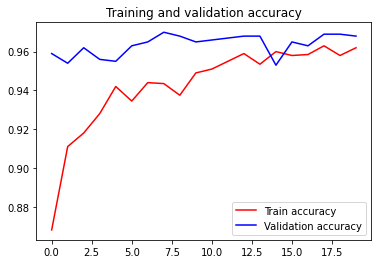

<Figure size 432x288 with 0 Axes>

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Train accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()